In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

sns.set(style="whitegrid")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/google-play-store-reviews/reviews.csv


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Visualizamos los datos de las resenas y su rating

Total de registros: 12495
                                             content  score
0                      I cannot open the app anymore      1
1  I have been begging for a refund from this app...      1
2  Very costly for the premium version (approx In...      1
3  Used to keep me organized, but all the 2020 UP...      1
4                                Dan Birthday Oct 28      1


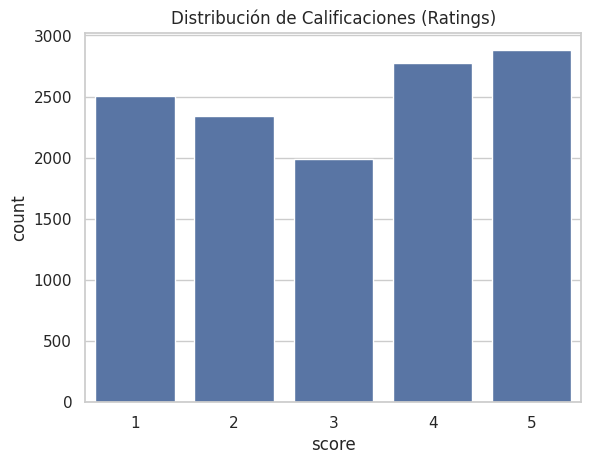

In [34]:
df = pd.read_csv('/kaggle/input/google-play-store-reviews/reviews.csv')
df = df[['content', 'score']].dropna()

print(f"Total de registros: {len(df)}")
print(df.head())

# Visualizar la distribución de los scores
sns.countplot(x='score', data=df)
plt.title('Distribución de Calificaciones (Ratings)')
plt.show()

# Preprocesamiento de datos


In [35]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # 1. Eliminar caracteres especiales y números
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    # 2. Convertir a minúsculas
    text = text.lower()
    # 3. Tokenización y eliminación de stopwords + Lemmatización
    tokens = text.split()
    cleaned_tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    
    return " ".join(cleaned_tokens)

# Aplicar la limpieza (esto puede tardar un poco en Kaggle)
df['cleaned_content'] = df['content'].apply(clean_text)
print("Texto limpio ejemplo:", df['cleaned_content'].iloc[0])

Texto limpio ejemplo: cannot open app anymore


# Vectorizacion para conertir palabras a numeros.

In [36]:
tfidf = TfidfVectorizer(max_features=2500) # Limitamos a las 2500 palabras más importantes
X = tfidf.fit_transform(df['cleaned_content']).toarray()
y = df['score'].values

# Dividir en set de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Forma de X_train: {X_train.shape}")

Forma de X_train: (9996, 2500)


# Entrenamiento del modelo 
## Usamos la GPU accelerator
### Ademas usamos optuna recomendado por Gemini para poder hacer una exploracion de los mejores parametros de fine tunning de nuestro modelo

In [37]:
import optuna
import xgboost as xgb

def objective(trial):
    # Definimos los rangos de búsqueda
    param = {
        'device': "cuda",
        'tree_method': "hist",
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }
    
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

# Creamos el estudio y optimizamos
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20) # Probaremos 20 combinaciones inteligentes

print("Mejor RMSE:", study.best_value)
print("Mejores parámetros:", study.best_params)

[I 2026-01-13 05:25:18,687] A new study created in memory with name: no-name-abdabd90-034f-47c2-a65d-2a26e61aacad
[I 2026-01-13 05:25:41,180] Trial 0 finished with value: 1.0435109532891351 and parameters: {'n_estimators': 1564, 'max_depth': 9, 'learning_rate': 0.03323079414331734, 'subsample': 0.8283865176729426, 'colsample_bytree': 0.6256131664536666}. Best is trial 0 with value: 1.0435109532891351.
[I 2026-01-13 05:26:05,361] Trial 1 finished with value: 1.0647279157209042 and parameters: {'n_estimators': 1940, 'max_depth': 8, 'learning_rate': 0.06815514137818746, 'subsample': 0.577425188679014, 'colsample_bytree': 0.8350917172660473}. Best is trial 0 with value: 1.0435109532891351.
[I 2026-01-13 05:26:31,538] Trial 2 finished with value: 1.0477422851009042 and parameters: {'n_estimators': 1399, 'max_depth': 10, 'learning_rate': 0.058969655959301544, 'subsample': 0.731749783971584, 'colsample_bytree': 0.8496001751796493}. Best is trial 0 with value: 1.0435109532891351.
[I 2026-01-13

Mejor RMSE: 1.0435109532891351
Mejores parámetros: {'n_estimators': 1564, 'max_depth': 9, 'learning_rate': 0.03323079414331734, 'subsample': 0.8283865176729426, 'colsample_bytree': 0.6256131664536666}


In [38]:
model_final = xgb.XGBRegressor(**study.best_params, device="cuda")

model_final.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)
y_pred = model_final.predict(X_test)

# Evaluacion de Resultados

--- Métricas de Regresión ---
RMSE: 1.0435
R2 Score: 0.4820

--- Análisis de Error Práctico ---
Predicciones con error <= 1 estrella: 1627 de 2499
Precisión práctica: 65.11%


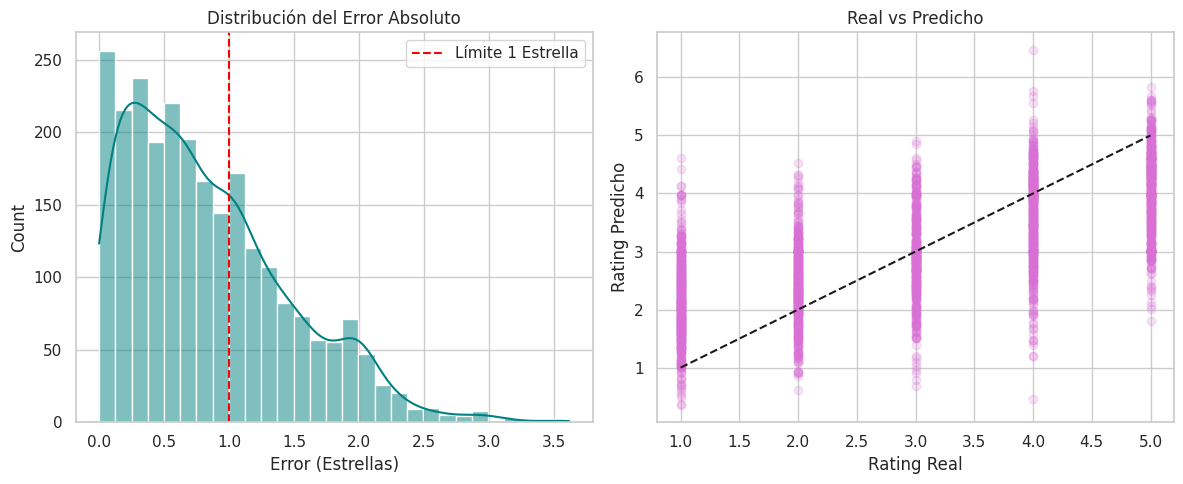

In [39]:
# 1. Calcular métricas estándar
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# 2. Calcular la diferencia absoluta
# Comparamos el valor real vs la predicción del regresor
diferencias = np.abs(y_test - y_pred)

# 3. Contar cuántas predicciones están dentro del margen de 1 estrella
dentro_de_uno = np.sum(diferencias <= 1.0)
total = len(y_test)
porcentaje_acierto = (dentro_de_uno / total) * 100

print(f"--- Métricas de Regresión ---")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"\n--- Análisis de Error Práctico ---")
print(f"Predicciones con error <= 1 estrella: {dentro_de_uno} de {total}")
print(f"Precisión práctica: {porcentaje_acierto:.2f}%")

# 4. Visualización del Error
plt.figure(figsize=(12, 5))

# Subplot 1: Histograma de los errores
plt.subplot(1, 2, 1)
sns.histplot(diferencias, kde=True, color='teal')
plt.axvline(1.0, color='red', linestyle='--', label='Límite 1 Estrella')
plt.title('Distribución del Error Absoluto')
plt.xlabel('Error (Estrellas)')
plt.legend()

# Subplot 2: Real vs Predicho
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.2, color='orchid')
plt.plot([1, 5], [1, 5], '--k') # Línea de perfección
plt.title('Real vs Predicho')
plt.xlabel('Rating Real')
plt.ylabel('Rating Predicho')

plt.tight_layout()
plt.show()

# Evaluacio de Resultados y puesta en marcha

In [40]:
def predict_my_review(text):
    cleaned = clean_text(text)
    vectorized = tfidf.transform([cleaned]).toarray()
    prediction = model_final.predict(vectorized)
    return prediction[0]

# Ejemplo de uso
mi_resena = "This app is amazing, it changed my life but it crashes sometimes."
print(f"Reseña: {mi_resena}")
print(f"Rating estimado: {predict_my_review(mi_resena):.2f} estrellas")

Reseña: This app is amazing, it changed my life but it crashes sometimes.
Rating estimado: 4.31 estrellas


In [41]:
# Guardar el modelo en el directorio de salida de Kaggle
model_final.save_model('/kaggle/working/modelo_app_reviews.json')
print("Modelo guardado exitosamente como 'modelo_app_reviews.json'")

Modelo guardado exitosamente como 'modelo_app_reviews.json'
